In [2]:
import pandas as pd
from numpy.random import choice
from my_pickle import unpickle_it
import matplotlib.pyplot as plt

In [3]:
user_df = unpickle_it('user_df')
convo_df = unpickle_it('convo_df')

print("Make sure we're not useing ECT data")
print(pd.to_datetime(convo_df.timestamp.max()*1000000))

Make sure we're not useing ECT data
2017-10-02 01:35:58.644000


# CELLS TO BE COPY-PASTED INTO .PY FILE

In [5]:
# are user ids unique?
print(len(user_df.index))
print(len(user_df.index.unique())) 

32436
32436


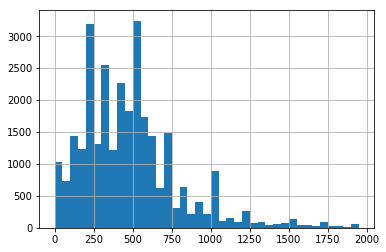

,created,updated,about,has_about,len_about,available,birthday,age,collegeId,emailVerified,...,smokingOk,term,work,messages_sent,responses_received,attractiveness,messages_received,responses_sent,selectivity,cost_range
uid,,,,,,,,,,,,,,,,,,,,,
0a9yOPKFSH,2017-06-19 03:31:08,2018-01-04 21:24:41,,False,0,nan,1992-01-01,26.0,NaN,1,...,0.0,12.0,SEG,7.0,2.0,0.285714,9.0,2.0,0.777778,150.0
0owxBbcyZ6,2017-10-12 00:32:29,2018-01-04 03:05:50,,False,0,nan,1974-01-01,44.0,NaN,1,...,1.0,NaN,WA State,0.0,0.0,0.000000,7.0,0.0,0.000000,NaN


In [11]:
user_df['cost_range'] = user_df.maxCost-user_df.minCost
user_df.cost_range.hist(bins=range(0,2000,50))
plt.show()
user_df.head(2)

In [6]:
def remove_bad_uids(df, user_df):
    ''' 
    removes and rows of the df that have uids not in uids
    '''
    uids = set(user_df.index)
    df['flag1'] = df.first_uid.apply(lambda x: x not in uids)
    df['flag2'] = df.second_uid.apply(lambda x: x not in uids)
    df['flag'] = df.flag1 | df.flag2
    
    df = df.drop(df[df.flag].index)

    df = df.drop(['flag1','flag2','flag'], axis=1)
    return df
    

convo_df = remove_bad_uids(convo_df, user_df)  
len(convo_df)

10937

In [17]:
def get_rent_range(first_user, second_user):
    max1 = first_user.maxCost
    max2 = second_user.maxCost
    min1 = first_user.minCost
    min2 = second_user.minCost
    if max1*max2*min1*min2 > 0:
        upper = min(first_user.maxCost,second_user.maxCost)
        lower = max(first_user.minCost,second_user.minCost)
        if upper-lower > 0: return upper-lower
        else: return 0
    else: return 175
    
def test_get_rent_range():    
    yes1 = '0a9yOPKFSH'
    yes2 = '013LzOrVju'
    no1 = '0UBLgJIHgz'
    no2 = '0EWNOmyQmW'
    low = '01DE0NCjwh'
    high = '02GDyQPLII'
    print(get_rent_range(user_df.loc[yes1], user_df.loc[yes2])) # should be 150
    print(get_rent_range(user_df.loc[yes1], user_df.loc[no1]))  # should be 175
    print(get_rent_range(user_df.loc[no2], user_df.loc[no1]))   # should be 175
    print(get_rent_range(user_df.loc[low], user_df.loc[high]))  # should be 0

test_get_rent_range()

150.0
175
175
0


In [8]:
def get_average_overlap(df,samples):
    # to find average overlap of two users' rent ranges
    # comes out to about $175
    s = 0
    for n in range(samples):
        two_users = choice(user_df[user_df.cost_range>0].index,2)
        overlap = user_df.loc[two_users,'maxCost'].min()-user_df.loc[two_users,'minCost'].max()
        if overlap < 0: overlap = 0
        s += overlap
    return s/samples

In [22]:
def get_inverse_distance(first_user, second_user):
    x1 = first_user.longitude
    x2 = second_user.latitude
    y1 = first_user.longitude
    y2 = second_user.latitude
    return ((x2-x1)**2+(y2-y1)**2)**(-.5)

In [ ]:
def get_similar_roommates(first_user, second_user):
    

In [31]:
def feature_time(df, user_df):
    '''
    age_dif: difference in ages between users
    rent_overlap: buy how much do their ideal rent ranges overlap
    same_gender: m/m or f/f
    same_relate:  are they both in relationships or single?
    same_clean: are the both clean/messy
    same_night: are they both early-birds or night owls?
    same_student: are they both students?
    sender_attractiveness: do people generally respond to this senders messages?
    receiver_selectivity: does this receiver generally respond to peopls messages?
    '''
    
    ad,ro,di,sg,sr,sc,sn,ss,sm,st,sa,rs = [],[],[],[],[],[],[],[],[],[],[],[]

    for index, row in df.iterrows():
        first = user_df.loc[str(row.first_uid)]
        second = user_df.loc[str(row.second_uid)]
        ad.append(abs(first.age - second.age))
        ro.append(get_rent_range(first, second))
        di.append(get_inverse_distance(first, second))
        sg.append(first.gender == second.gender)
        sr.append(first.inRelationship == second.inRelationship)
        sc.append(first.isClean == second.isClean)
        sn.append(first.isNight == second.isNight)
        ss.append(first.isStudent == second.isStudent)
        sm.append(first.smokingOk == second.smokingOk)
        st.append(first.term == second.term)
        sa.append(first.attractiveness)
        rs.append(second.selectivity)

    df['age_dif'] = ad
    df['rent_overlap'] = ro
    df['inverse_distance'] = di
    df['same_gender'] = sg
    df['same_relate'] = sr
    df['same_clean'] = sc
    df['same_night'] = sn
    df['same_student'] = ss
    df['same_smoking'] = sm
    df['same_term'] = st
    df['sender_attractiveness'] = sa
    df['receiver_selectivity'] = rs

    return df

In [34]:
X = feature_time(convo_df, user_df)
X.head()

,conv_id,response,first_uid,second_uid,first_mid,second_mid,timestamp,age_dif,same_gender,rent_overlap,same_relate,same_clean,same_night,same_student,sender_attractiveness,receiver_selectivity,inverse_distance,same_smoking,same_term
14397,nQYG2Z9elg8Ws3QWmC4B,True,nQYG2Z9elg,8Ws3QWmC4B,-KWZ6j5vHnNWPD90JJ18,-KWUqwqvF7RfcRaEqtL6,1479148499453,2.0,True,100.0,True,False,True,False,0.500000,0.933333,0.004258,False,False
5891,QkEYa5ZJNZ6Iol6V4bND,True,6Iol6V4bND,QkEYa5ZJNZ,-KW_4Mfb_a0bNlSYtwN0,-KW_4ID8hJs4Hw_lU81P,1479164656685,7.0,True,450.0,False,True,False,True,0.666667,0.000000,0.004413,False,True
14184,n2ffQeQMriYL4dlYdM1W,True,YL4dlYdM1W,n2ffQeQMri,-KYLE9PvLEsrBHm36puZ,-KYLDu4jBBzdhx8VdHcD,1481063049035,7.0,False,1000.0,False,True,True,True,0.750000,0.235294,0.004424,True,True
8589,YL4dlYdM1W6Iol6V4bND,True,YL4dlYdM1W,6Iol6V4bND,-KYLEFnJYvUAIbEW4uvC,-KYLPbedA40Fz69oKze4,1481063075142,12.0,True,0.0,False,False,True,False,0.750000,0.714286,0.004423,True,True
14404,nQYG2Z9elgn2ffQeQMri,False,n2ffQeQMri,nQYG2Z9elg,-KYLEyp9_LdGKEMioVyZ,None,1481063263841,12.0,False,950.0,False,False,False,False,0.722222,0.857143,0.004415,False,True
